In [4]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/Users/liaojingwen/Desktop//kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/liaojingwen/Desktop//kaggle/input/.DS_Store
/Users/liaojingwen/Desktop//kaggle/input/emotion.csv
/Users/liaojingwen/Desktop//kaggle/input/sampleSubmission.csv
/Users/liaojingwen/Desktop//kaggle/input/data_identification.csv
/Users/liaojingwen/Desktop//kaggle/input/tweets_DM.json


In [20]:
import json
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# ensure nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/liaojingwen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
data = []
with open('/Users/liaojingwen/Desktop/kaggle/input/tweets_DM.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))
f.close()

In [2]:
import json
import re
import emoji
import pandas as pd
import os

# Define a dictionary to replace emojis with corresponding keywords
emoji_dict = {
    '😂': '[joy]',
    '❤️': '[love]',
    '😍': '[adoration]',
    '😭': '[cry]',
    '❤': '[care]',
    '😊': '[happy]',
    '🙏': '[pray]',
    '😘': '[kiss]',
    '💕': '[love_each_other]',
    '🔥': '[fire]',
    '😩': '[weary]',
    '🤔': '[think]',
    '💯': '[perfect]',
    '💙': '[loyalty]',
    '🙄': '[annoyed]',
    '😁': '[happy]',
    '🙌': '[celebrate]',
    '🙏🏾': '[pray]',
    '👍': '[approve]',
    '🙏🏽': '[pray]'
}

# Function to clean tweet text
def clean_tweet(text, emoji_dict):
    # Replace emojis with keywords
    for emj, keyword in emoji_dict.items():
        text = text.replace(emj, keyword)
    # Remove other emojis
    text = emoji.replace_emoji(text, replace='')
    # Remove <LH> tags
    text = re.sub(r'<LH>', '', text)
    # Remove extra spaces
    text = text.strip()
    return text

# Read tweet data from JSON file
data1 = []
with open('/Users/liaojingwen/Desktop/kaggle/input/tweets_DM.json', 'r') as f:
    for line in f:
        data1.append(json.loads(line))

# Process each tweet and save the result
processed_tweets = []
for entry in data1:
    # Check for '_source' and 'tweet' keys
    if '_source' in entry and 'tweet' in entry['_source']:
        tweet = entry['_source']['tweet']
        # Check for 'text' key in 'tweet'
        if 'text' in tweet:
            tweet_text = tweet['text']
            cleaned_text = clean_tweet(tweet_text, emoji_dict)
            # Create a processed tweet record
            processed_tweet = {
                '_source': {
                    'tweet': tweet.copy()
                }
            }
            # Update with cleaned text
            processed_tweet['_source']['tweet']['text'] = cleaned_text
            processed_tweets.append(processed_tweet)
        else:
            print("Missing 'text' key in the record")
    else:
        print("Missing '_source' or 'tweet' key in the record")

# Save processed tweet data to a JSON file
with open('output_path', 'w') as outfile:
    json.dump(processed_tweets, outfile, ensure_ascii=False, indent=4)

# Convert processed data to DataFrame
df_processed = pd.DataFrame(processed_tweets)

# Define output directory and file name
output_dir = 'Users/liaojingwen/Desktop/kaggle/working/'
output_file = 'tweets_DM_filtered_3.json'

# Check and create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the processed DataFrame as a JSON file
output_path = os.path.join(output_dir, output_file)
df_processed.to_json(output_path, orient='records', lines=True, force_ascii=False)

# Load the cleaned JSON file into a list for further processing
data = []
with open('Users/liaojingwen/Desktop/kaggle/working/tweets_DM_filtered_3.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))
f.close()
print("ok")


ok


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load datasets
emotion = pd.read_csv('/Users/liaojingwen/Desktop/kaggle/input/emotion.csv')
data_identification = pd.read_csv('/Users/liaojingwen/Desktop/kaggle/input/data_identification.csv')

# ======== Data Processing ========
# 1. Extract tweet_id, hashtags, and text from JSON data
df = pd.DataFrame(data)  # Assuming `data` is a dictionary or JSON-like structure

_source = df['_source'].apply(lambda x: x['tweet'])
df = pd.DataFrame({
    'tweet_id': _source.apply(lambda x: x['tweet_id']),
    'hashtags': _source.apply(lambda x: x['hashtags']),
    'text': _source.apply(lambda x: x['text']),
})

# 2. Merge dataset labels (train/test)
df = df.merge(data_identification, on='tweet_id', how='left')

# 3. Split into training and testing datasets
train_data = df[df['identification'] == 'train']
test_data = df[df['identification'] == 'test']

# 4. Merge emotion labels into training data
train_data = train_data.merge(emotion, on='tweet_id', how='left')

# 5. Remove duplicate texts in training data
train_data.drop_duplicates(subset=['text'], keep=False, inplace=True)

# ======== Training Data Preparation ========
# 1. Sample 30% of the training data
train_data_sample = train_data.sample(frac=0.3, random_state=42)

# 2. Extract target variable (emotion) and feature variable (text)
y_train_data = train_data_sample['emotion']
X_train_data = train_data_sample['text']

# 3. Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_train_data, y_train_data, test_size=0.2, random_state=42, stratify=y_train_data
)


In [4]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liaojingwen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [44]:
# ======== 文本處理與 Word2Vec 訓練 ========
# 1. 將文本分詞
def preprocess_text(text_series):
    return text_series.apply(word_tokenize)

X_train_tokens = preprocess_text(X_train)
X_test_tokens = preprocess_text(X_test)

# 2. 訓練 Word2Vec 模型
word2vec_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)

# 3. 將每個文本轉換為向量（平均詞向量）
def text_to_avg_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

X_train_vectors = X_train_tokens.apply(lambda x: text_to_avg_vector(x, word2vec_model)).tolist()
X_test_vectors = X_test_tokens.apply(lambda x: text_to_avg_vector(x, word2vec_model)).tolist()

# ======== 標籤編碼 ========
# 1. 將情緒類別轉換為數值型
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# ======== 模型訓練 ========
# 1. 訓練隨機森林分類器
clf = RandomForestClassifier()
clf.fit(X_train_vectors, y_train_encoded)

# ======== 模型評估 ========
# 1. 預測測試集
y_pred = clf.predict(X_test_vectors)

# 2. 計算準確率
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred):.4f}")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

# ======== 測試數據預測 ========
# 1. 準備測試數據的文本特徵
X_test_data = preprocess_text(test_data['text'])
X_test_data_vectors = X_test_data.apply(lambda x: text_to_avg_vector(x, word2vec_model)).tolist()

# 2. 預測測試數據情緒
y_test_pred = clf.predict(X_test_data_vectors)

# ======== 結果輸出 ========
# 1. 將數值標籤轉換回文字標籤
y_pred_labels = le.inverse_transform(y_test_pred)

# 2. 保存提交檔案
submission = pd.DataFrame({
    'id': test_data['tweet_id'],
    'emotion': y_pred_labels
})


Accuracy: 0.4516
              precision    recall  f1-score   support

       anger       0.98      0.08      0.15      1826
anticipation       0.57      0.36      0.44     11429
     disgust       0.33      0.15      0.21      6401
        fear       0.66      0.06      0.11      2911
         joy       0.44      0.88      0.58     23505
     sadness       0.41      0.32      0.36      8844
    surprise       0.93      0.07      0.13      2188
       trust       0.64      0.10      0.17      9323

    accuracy                           0.45     66427
   macro avg       0.62      0.25      0.27     66427
weighted avg       0.51      0.45      0.39     66427



In [12]:
with open('/Users/liaojingwen/Desktop/kaggle/Users/liaojingwen/Desktop/kaggle/working/tweets_DM_filtered_1.json', 'r') as f:
    for line in f:
        print(json.loads(line))  # Print a sample record to understand the structure
        break



{'_source': {'tweet': {'hashtags': ['Snapchat'], 'tweet_id': '0x376b20', 'text': 'People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that\'s'}}}


In [17]:
# Assign a placeholder label for missing emotion data
df['emotion'] = 'neutral'  # Default to 'neutral' for all rows

if '_source.tweet.emotion' in df.columns:
    df['emotion'] = df['_source.tweet.emotion'].fillna('neutral')  # Replace missing with 'neutral'
else:
    print("No 'emotion' column found. Adding a placeholder.")
    df['emotion'] = 'neutral'  # Add a new column with placeholder values


No 'emotion' column found. Adding a placeholder.


In [45]:
submission.head()

,id,emotion
2,0x28b412,joy
4,0x2de201,anticipation
9,0x218443,sadness
30,0x2939d5,joy
33,0x26289a,joy


In [46]:
submission_df.to_csv('/Users/liaojingwen/Desktop/kaggle/output/submission.csv', index=False)

In [54]:
import pandas as pd

# Load your submission and sample files
submission_df = pd.read_csv('/Users/liaojingwen/Desktop/kaggle/output/submission 4.csv')
sample_submission_df = pd.read_csv('/Users/liaojingwen/Desktop/kaggle/input/sampleSubmission.csv')

# Step 1: Check for duplicates in the current submission
if submission_df['id'].duplicated().any():
    print("Duplicates found in the current submission file!")
    submission_df = submission_df.drop_duplicates(subset='id')

# Step 2: Check for duplicates in the sample file
if sample_submission_df['id'].duplicated().any():
    print("Duplicates found in the sample submission file!")
    sample_submission_df = sample_submission_df.drop_duplicates(subset='id')

# Step 3: Identify missing IDs
existing_ids = set(submission_df['id'])
missing_rows = sample_submission_df[~sample_submission_df['id'].isin(existing_ids)]

# Calculate the number of rows to add
missing_row_count = 411972 - submission_df.shape[0]

# Step 4: Add only the required number of rows
missing_rows = missing_rows.head(missing_row_count)

# Assign a default emotion to missing rows
missing_rows['emotion'] = 'neutral'

# Combine the current submission with the missing rows
final_submission_df = pd.concat([submission_df, missing_rows], ignore_index=True)

# Step 5: Ensure no duplicates in the final DataFrame
final_submission_df = final_submission_df.drop_duplicates(subset='id')

# Validate final row count
assert final_submission_df.shape[0] == 411972, "Final submission does not have 411,972 rows!"

# Save the final corrected submission file
final_submission_df.to_csv('/Users/liaojingwen/Desktop/kaggle/output/submission 5.csv', index=False)

print("Final submission file created with unique IDs and 411,972 rows.")


Duplicates found in the current submission file!
Final submission file created with unique IDs and 411,972 rows.


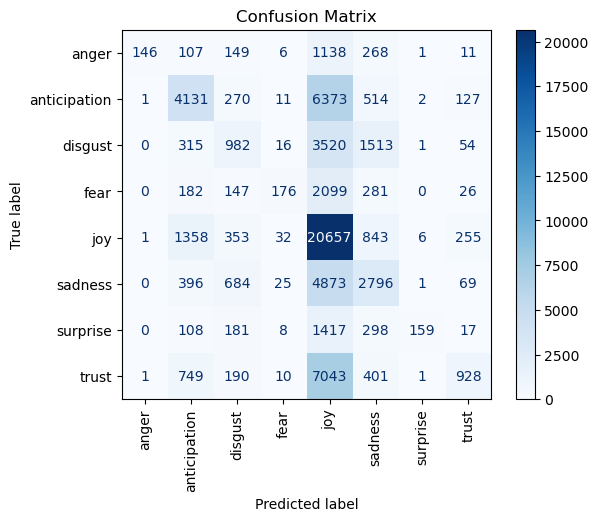


 ---- 

Confusion Matrix:
[[  146   107   149     6  1138   268     1    11]
 [    1  4131   270    11  6373   514     2   127]
 [    0   315   982    16  3520  1513     1    54]
 [    0   182   147   176  2099   281     0    26]
 [    1  1358   353    32 20657   843     6   255]
 [    0   396   684    25  4873  2796     1    69]
 [    0   108   181     8  1417   298   159    17]
 [    1   749   190    10  7043   401     1   928]]

 ---- 


Classification Report:
              precision    recall  f1-score   support

       anger       0.98      0.08      0.15      1826
anticipation       0.56      0.36      0.44     11429
     disgust       0.33      0.15      0.21      6401
        fear       0.62      0.06      0.11      2911
         joy       0.44      0.88      0.58     23505
     sadness       0.40      0.32      0.35      8844
    surprise       0.93      0.07      0.13      2188
       trust       0.62      0.10      0.17      9323

    accuracy                           0.45

In [38]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd

# ======== Text Preprocessing and Word2Vec Training ========

# 1. Tokenize text data
def preprocess_text(text_series):
    return text_series.apply(word_tokenize)

X_train_tokens = preprocess_text(X_train)
X_test_tokens = preprocess_text(X_test)

# 2. Train Word2Vec model
word2vec_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)

# 3. Convert each text to an average vector
def text_to_avg_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

X_train_vectors = X_train_tokens.apply(lambda x: text_to_avg_vector(x, word2vec_model)).tolist()
X_test_vectors = X_test_tokens.apply(lambda x: text_to_avg_vector(x, word2vec_model)).tolist()

# ======== Label Encoding ========

# 1. Convert emotion labels to numerical values
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# ======== Model Training ========

# 1. Train Random Forest Classifier
clf = RandomForestClassifier()
clf.fit(X_train_vectors, y_train_encoded)

# ======== Model Evaluation ========

# 1. Predict test set
y_pred = clf.predict(X_test_vectors)

# 2. Calculate accuracy
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred):.4f}")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

# ======== Predicting on Test Data ========

# 1. Prepare features for test data
X_test_data = preprocess_text(test_data['text'])
X_test_data_vectors = X_test_data.apply(lambda x: text_to_avg_vector(x, word2vec_model)).tolist()

# 2. Predict emotions for test data
y_test_pred = clf.predict(X_test_data_vectors)

# ======== Output Results ========

# 1. Convert numerical labels back to text labels
y_pred_labels = le.inverse_transform(y_test_pred)

# 2. Save submission file
submission = pd.DataFrame({
    'id': test_data['tweet_id'],
    'emotion': y_pred_labels
})


In [ ]:
# Rename 'tweet_id' to 'id'
submission_df.rename(columns={'tweet_id': 'id'}, inplace=True)

# Reorder columns to match the sample structure
submission_df = submission_df[['id', 'emotion']]

# Save the file in the desired structure
submission_df.to_csv('/Users/liaojingwen/Desktop/kaggle/output/submission.csv', index=False)
